In [7]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as ti
from matplotlib import cm
from tqdm import tqdm
from numba import cuda
import cupy as cp

# # for pytorch
# from torch import zeros, np.array, roll, sin, sqrt, linspace
# from torch import sum as tsum
# import torch

In [8]:
# print("Torch version:",torch.__version__)

# torch.cuda.get_device_name(0)


In [9]:
# selecting device as cuda if available otherwise will set to cpu
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [10]:
@cuda.jit
def macroscopic(fin, nx, ny, v):
    rho = np.sum(fin,axis=0)    # sending data to device
    # rho_gpu = cuda.to_device(rho)
    u = np.zeros((2,nx,ny))  # sending data to device
    # u_gpu = cuda.to_device(u)
    i = cuda.grid(1)
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u


In [11]:
@cuda.jit
def equilibrium(rho, u, v, t, nx, ny):
    usqr = (3/2)*(u[0]**2+u[1]**2)
    feq = np.zeros((9,nx,ny))
    i = cuda.grid(1)
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
    return feq

In [12]:

def obstacle_fun(cx, cy, r):
    def inner(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return inner


In [13]:

# def inivel(uLB, ly, d, nx, ny):
#     _,yy = torch.meshgrid(linspace(0, nx - 1, nx), linspace(0, ny - 1, ny))
#     yy.to(device)
#     vel = zeros((d, nx, ny)).to(device)
#     for dir in range(d):
#         vel[dir,:,:] = (1-dir) * uLB * (1+1e-4*sin(yy/ly*2*np.pi))
#     return vel


def inivel( uLB, ly):
    def inner(d,x,y):
        return (1-d) * uLB * (1+1e-4*np.sin(y/ly*2*np.pi))
    return inner
    


In [14]:
Re = 10.0                  # Reynolds number
#------------------------------------------------------------------------------
maxIter = 10000
nx,ny = 420,180             # Domain dimensions
ly = ny-1
uLB = 0.04                  # Inlet velocity NON PHYSICAL??
cx,cy,r = nx//4,ny//2,ny/9  # cylinder coordinates and radius (as integers)
nulb = uLB*r/Re             # Viscosity
omega = 1 / (3*nulb+0.5)    # Relaxation parameter


In [15]:

# lattice velocities
v = np.array([
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ])

# weights
t = np.array([
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ])

In [16]:
col_0 = np.array([0,1,2])
col_1 = np.array([3,4,5])
col_2 = np.array([6,7,8])



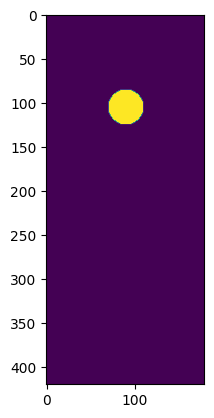

In [17]:
# kwargs['shape'] = [nx, ny]
# instantiate the cylindrical obstacle
obstacle = np.array(np.fromfunction(obstacle_fun(cx,cy,r),(nx, ny)))
if True:
  plt.imshow(obstacle)


In [18]:

# initial velocity profile
vel = np.fromfunction(inivel(uLB,ly),(2,nx,ny))
# vel = inivel(uLB, ly, 2, nx, ny)
tpb = 16
size = 10000
block = (size // tpb)
# initialize fin to equilibirum (rho = 1)
fin = equilibrium[block, tpb](1,vel,v,t,nx,ny)

#==============================================================================
#   Time-Stepping
#==============================================================================
t0 = ti()
for time in tqdm(range(maxIter)):
    # outflow boundary condition (right side) NEUMANN BC! No gradient
    fin[col_2,-1,:] = fin[col_2,-2,:]
    # compute macroscopic variables
    
    rho,u = macroscopic[block, tpb](fin,nx,ny,v)

    # inlet boundary condition (left wall)
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:])*( tsum(fin[col_1,0,:], axis = 0)+
                                2*tsum(fin[col_2,0,:], axis = 0))

    # feq = equilibrium(rho,u,v,t,nx,ny)
    fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]

    # Collide
    fout = fin - omega*(fin-feq)

    # bounceback
    for i in range(9):
        fout[i,obstacle] = fin[8-i,obstacle]

    # stream
    for i in range(9):
        # be careful with this -> numpy.roll cycles through an array by an axis
        # and the last element becomes the first. this implements a periodic
        # boundary in a very compact syntax, but needs to be reworked for other
        # implementations
        fin[i,:,:] = np.roll(
                          np.roll(
                                fout[i,:,:], v[i,0], axis = 0
                               ),
                          v[i,1], axis = 1
                          )

    # Output an image every 100 iterations
    if (time%100 == 0):
        plt.clf()
        u_temp = u
        x_temp = int(round(5 * nx / ny))
        y_temp = int(round(5))
        plt.imshow(np.sqrt(u_temp[0]**2+u_temp[1]**2).T, cmap= 'Reds')
        plt.savefig("./test/vel{0:03d}.png".format(time//100))
tf = ti() - t0

print("time to execute = ",tf)

/tmp/ipykernel_5147/341955023.py:4: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/cisco581b/.local/lib/python3.8/site-packages/numba/core/untyped_passes.py", line 125, in run_pass
    raise TypeError("Signature mismatch: %d argument types given, "

  feq = np.zeros((9,nx,ny))


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function pow>) found for signature:
 
 >>> pow(array(float64, 2d, C), Literal[int](2))
 
There are 4 candidate implementations:
[1m   - Of which 2 did not match due to:
   Operator Overload in function 'pow': File: unknown: Line unknown.
     With argument(s): '(array(float64, 2d, C), int64)':[0m
[1m    No match for registered cases:
     * (int64, int64) -> int64
     * (int64, uint64) -> int64
     * (uint64, int64) -> int64
     * (uint64, uint64) -> uint64
     * (float32, int32) -> float32
     * (float32, int64) -> float32
     * (float32, uint64) -> float32
     * (float64, int32) -> float64
     * (float64, int64) -> float64
     * (float64, uint64) -> float64
     * (float32, float32) -> float32
     * (float64, float64) -> float64
     * (complex64, complex64) -> complex64
     * (complex128, complex128) -> complex128[0m
[1m   - Of which 2 did not match due to:
   Overload of function 'pow': File: numba/experimental/jitclass/overloads.py: Line 0.
     With argument(s): '(array(float64, 2d, C), int64)':[0m
[1m    No match.[0m
[0m
[0m[1mDuring: typing of intrinsic-call at /tmp/ipykernel_5147/341955023.py (3)[0m
[1m
File "../../../../tmp/ipykernel_5147/341955023.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m
